In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
import time
import xgboost as xgb

In [3]:
data = pd.read_csv("output.csv")
df = data.drop(['Time'], axis=1)
number_of_houses = len(df.columns)
df

,PT41CV,PT44AL,PT15VP,PT69QG,PT43QL,PT17RW,PT87ZW
0,0.028,0.452,0.000,0.828,0.128,0.056,0.552
1,0.080,0.440,0.000,0.796,0.160,0.056,0.492
2,0.092,0.424,0.000,0.832,0.220,0.056,0.308
3,0.040,0.408,0.000,0.800,0.404,0.088,0.156
4,0.076,0.396,0.000,0.836,0.156,0.116,0.160
...,...,...,...,...,...,...,...
35027,0.120,0.448,0.108,0.220,0.164,0.144,0.368
35028,0.036,0.424,0.124,0.252,0.228,0.164,0.396
35029,0.064,0.392,0.148,0.268,0.224,0.220,0.356
35030,0.132,0.260,0.132,0.276,0.212,0.176,0.392


## Auxiliary functions

In [31]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()
    
    
def performance_metrics(preds: np.array, actuals: np.array):

    # calculate performance metrics
    
    mse = mean_squared_error(actuals, preds)
    mae = mean_absolute_error(actuals, preds)
    rmse = np.sqrt(mse)
    #print("wape test:",np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals)) * 100)
    #mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    wape = mae / actuals.mean() * 100
    r2 = r2_score(actuals, preds)

    # print performance metrics
    #print('MSE: %.4f' % mse)
    #print('RMSE: %.4f' % rmse)
    #print('MAE: %.4f' % mae)
    #print('WMAPE: %.4f' % wmape)
    print('WAPE: %.4f' % wape)
    #print('R2: %.4f' % r2)
    return mse, rmse, mae, wape, r2

def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train.values.ravel())
    preds = model.predict(X_test)
    scores = cross_validate(estimator, X_train, y_train.values.ravel(), scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_squared_error', 'neg_mean_absolute_error'])
    return model, preds, scores

In [32]:
def total_averaged_metrics(metrics_list):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged RMSE: {}".format(np.round(sum(j for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged MAE: {}".format(np.round(sum(k for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged WAPE: {}".format(np.round(sum(l for i, j, k, l, m in metrics_list)/len(metrics_list),3)))
    print("Total Averaged R2: {}".format(np.round(sum(m for i, j, k, l, m in metrics_list)/len(metrics_list),3)))


def last_energy_points(df, number_timesteps):
    X = pd.DataFrame()
    for i in range(1, (number_timesteps + 1) ):
        X[f'Energy_{i*15}'] = df.shift(i)
    X.dropna(inplace=True)
    X.reset_index(drop=True, inplace=True)
    y = pd.DataFrame(df[number_timesteps:])
    y.reset_index(drop=True, inplace=True)
    y.columns = ["Energy"]
    return X, y

def build_predict_show(df, number_timesteps, estimator, normalize=False, train_size=0.8, start_timestep=1 ):
    full_start = time.time()
    metrics_list = []
    for i in range(start_timestep,(number_timesteps + 1)):
        start = time.time()
        print("\nIteration ", i)
        X, y = last_energy_points(df, i)

        X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        if(normalize):
            scaler = MinMaxScaler().fit(X_train)
            X_train_norm = scaler.transform(X_train)
            X_test_norm = scaler.transform(X_test)
        model, preds, scores = build_model(estimator, X_train_norm, y_train_norm, X_test)
        mse, rmse, mae, mape, r2 = performance_metrics(preds, y_test.values.reshape(-1))
        cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
        cv_rmse = np.round(scores['test_neg_root_mean_squared_error'].mean() * (-1),4)
        cv_mae = np.round(scores['test_neg_mean_absolute_error'].mean() * (-1),4)
        cv_r2 = np.round(scores['test_r2'].mean(),5)
        print("CV MSE: {} ".format(cv_mse))
        print("CV RMSE: {} ".format(cv_rmse))
        print("CV MAE: {} ".format(cv_mae))
        print("CV R2: {} ".format(cv_r2))
        metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))
        print("\nElapsed time: %.3f seconds" % (time.time() - start))
    print("\nFull Elapsed time: %.3f seconds" % (time.time() - full_start))
    return model, preds, scores, metrics_list

def split_train_test_timeseries(X, y, train_size: int):
    n_train_samples = int(len(X) * train_size)
    X_train = X[:n_train_samples]
    X_test = X[n_train_samples:]
    y_train = y[:n_train_samples]
    y_test = y[n_train_samples:]
    return X_train, X_test, y_train, y_test

def show_graphic_per_timestep(metrics_list, number_timesteps, start_timestep=1):
    mse_list = []
    rmse_list = []
    mae_list = []
    wape_list = []
    r2_list = []

    for i in range(0,len(metrics_list)):
        mse_list.append(metrics_list[i][0])
        rmse_list.append(metrics_list[i][1])
        mae_list.append(metrics_list[i][2])
        wape_list.append(metrics_list[i][3])
        r2_list.append(metrics_list[i][4])
        
    plt.plot(range(start_timestep,(number_timesteps+1)), mse_list)
    plt.title('MSE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('MSE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), rmse_list)
    plt.title('RMSE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('RMSE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), mae_list)
    plt.title('MAE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('MAE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), wape_list)
    plt.title('WAPE per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('WAPE')
    plt.show()
    
    plt.plot(range(start_timestep,(number_timesteps+1)), r2_list)
    plt.title('R2 per past timestep')
    plt.xlabel('Number of past timesteps')
    plt.ylabel('R2')
    plt.show()
    

In [33]:
df_total = pd.DataFrame(df.sum(axis=1))
df_total.columns = ['Energy']
df_total

,Energy
0,2.044
1,2.024
2,1.932
3,1.896
4,1.740
...,...
35027,1.572
35028,1.624
35029,1.672
35030,1.580


## Preprocessing

In [34]:
X,y = last_energy_points(df_total, 8)
print(X.shape, y.shape)
X

(35024, 8) (35024, 1)


,Energy_15,Energy_30,Energy_45,Energy_60,Energy_75,Energy_90,Energy_105,Energy_120
0,1.568,1.792,1.764,1.740,1.896,1.932,2.024,2.044
1,1.604,1.568,1.792,1.764,1.740,1.896,1.932,2.024
2,1.112,1.604,1.568,1.792,1.764,1.740,1.896,1.932
3,0.896,1.112,1.604,1.568,1.792,1.764,1.740,1.896
4,0.840,0.896,1.112,1.604,1.568,1.792,1.764,1.740
...,...,...,...,...,...,...,...,...
35019,1.540,1.640,1.868,1.852,2.020,2.236,2.100,2.224
35020,1.572,1.540,1.640,1.868,1.852,2.020,2.236,2.100
35021,1.624,1.572,1.540,1.640,1.868,1.852,2.020,2.236
35022,1.672,1.624,1.572,1.540,1.640,1.868,1.852,2.020


## Test model

### Gradient Boosting

In [35]:
start_timestep = 2
number_timesteps = 12

In [36]:
model_gb, preds_gb, scores_gb, metrics_list_gb = build_predict_show(df_total, number_timesteps, GradientBoostingRegressor(random_state=42), start_timestep=start_timestep)


Iteration  2
WAPE: 21.5194
CV MSE: 0.43954 
CV RMSE: 0.66294 
CV MAE: 0.42874 
CV R2: 0.62479 

Elapsed time: 5.917 seconds

Iteration  3
WAPE: 21.0951
CV MSE: 0.43049 
CV RMSE: 0.65598 
CV MAE: 0.42799 
CV R2: 0.63712 

Elapsed time: 8.683 seconds

Iteration  4
WAPE: 21.0066
CV MSE: 0.43092 
CV RMSE: 0.65623 
CV MAE: 0.42868 
CV R2: 0.63296 

Elapsed time: 10.743 seconds

Iteration  5
WAPE: 21.1660
CV MSE: 0.42991 
CV RMSE: 0.65564 
CV MAE: 0.42701 
CV R2: 0.63793 

Elapsed time: 13.265 seconds

Iteration  6
WAPE: 21.1398
CV MSE: 0.43436 
CV RMSE: 0.65898 
CV MAE: 0.42887 
CV R2: 0.6338 

Elapsed time: 15.884 seconds

Iteration  7
WAPE: 21.3844
CV MSE: 0.4305 
CV RMSE: 0.65603 
CV MAE: 0.4264 
CV R2: 0.63378 

Elapsed time: 18.560 seconds

Iteration  8
WAPE: 21.0816
CV MSE: 0.43318 
CV RMSE: 0.65802 
CV MAE: 0.42957 
CV R2: 0.63378 

Elapsed time: 20.825 seconds

Iteration  9
WAPE: 21.1869
CV MSE: 0.43478 
CV RMSE: 0.65935 
CV MAE: 0.42942 
CV R2: 0.63301 

Elapsed time: 23.249 secon

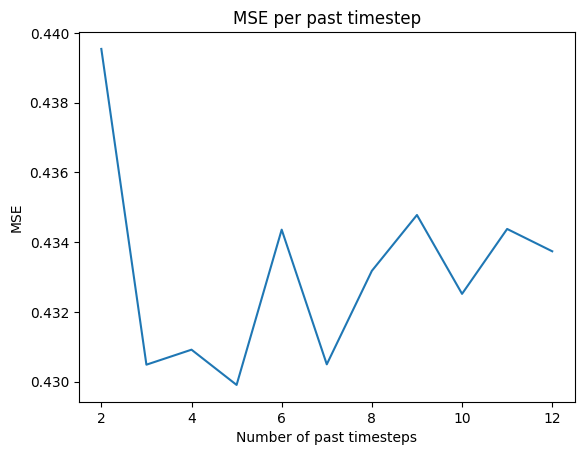

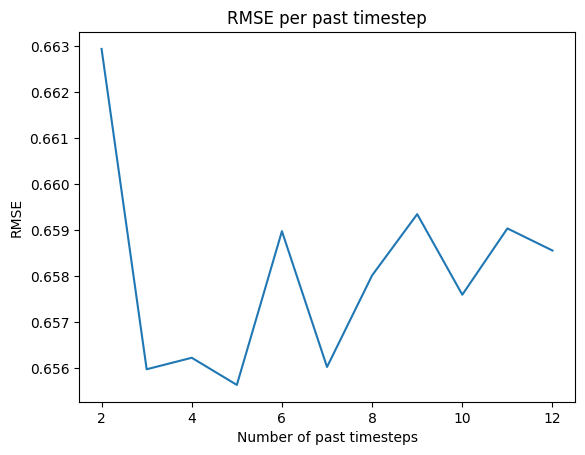

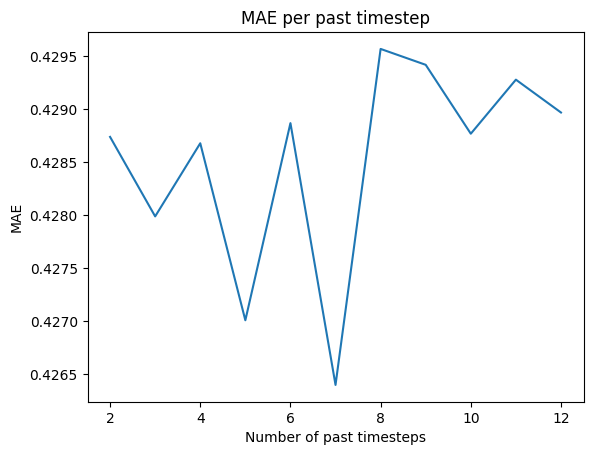

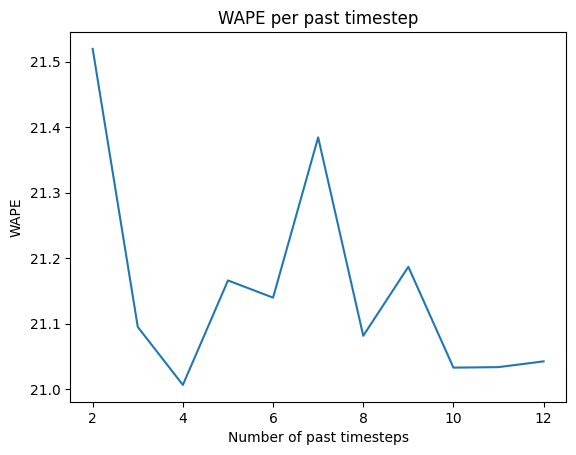

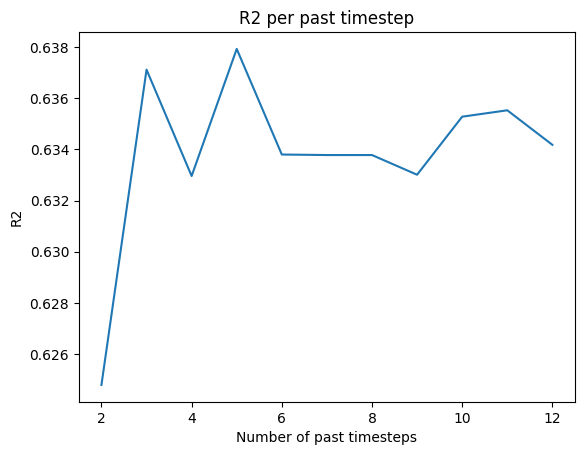

In [37]:
show_graphic_per_timestep(metrics_list_gb, number_timesteps, start_timestep)

### Random Forest

In [40]:
model_rf, preds_rf, scores_rf, metrics_list_rf = build_predict_show(df_total, number_timesteps, RandomForestRegressor(random_state=42), start_timestep=start_timestep)


Iteration  2
WAPE: 24.1669
CV MSE: 0.54035 
CV RMSE: 0.73504 
CV MAE: 0.49228 
CV R2: 0.54092 

Elapsed time: 28.056 seconds

Iteration  3
WAPE: 22.8603
CV MSE: 0.47998 
CV RMSE: 0.69277 
CV MAE: 0.46084 
CV R2: 0.59227 

Elapsed time: 47.565 seconds

Iteration  4
WAPE: 22.3895
CV MSE: 0.47194 
CV RMSE: 0.68684 
CV MAE: 0.45575 
CV R2: 0.60052 

Elapsed time: 51.402 seconds

Iteration  5
WAPE: 22.1719
CV MSE: 0.46606 
CV RMSE: 0.68263 
CV MAE: 0.4538 
CV R2: 0.60756 

Elapsed time: 62.438 seconds

Iteration  6
WAPE: 21.8972
CV MSE: 0.46055 
CV RMSE: 0.67858 
CV MAE: 0.44934 
CV R2: 0.60938 

Elapsed time: 72.351 seconds

Iteration  7
WAPE: 22.0539
CV MSE: 0.45501 
CV RMSE: 0.67444 
CV MAE: 0.44713 
CV R2: 0.61496 

Elapsed time: 82.477 seconds

Iteration  8
WAPE: 21.5700
CV MSE: 0.45781 
CV RMSE: 0.67656 
CV MAE: 0.44842 
CV R2: 0.61382 

Elapsed time: 98.508 seconds

Iteration  9
WAPE: 21.6456
CV MSE: 0.45182 
CV RMSE: 0.67211 
CV MAE: 0.44442 
CV R2: 0.61671 

Elapsed time: 116.930 

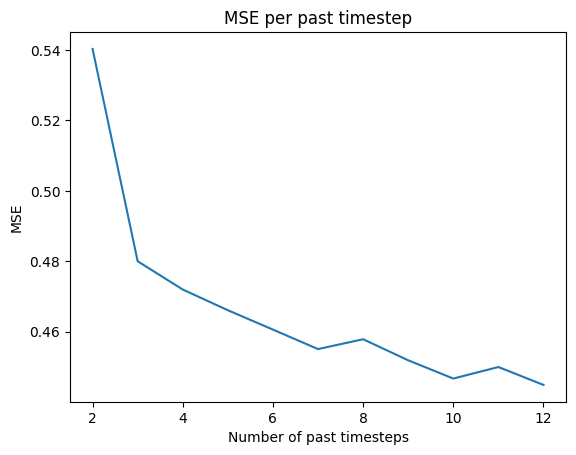

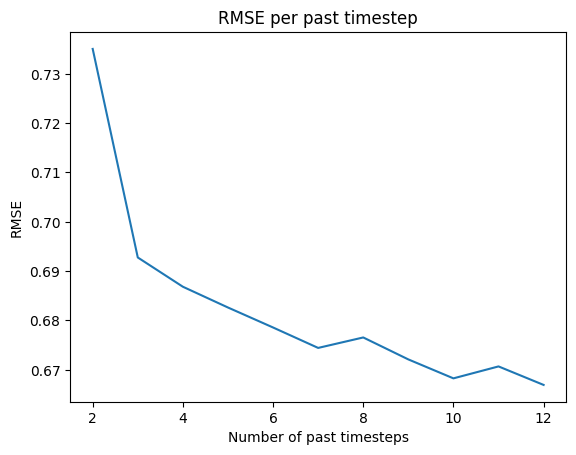

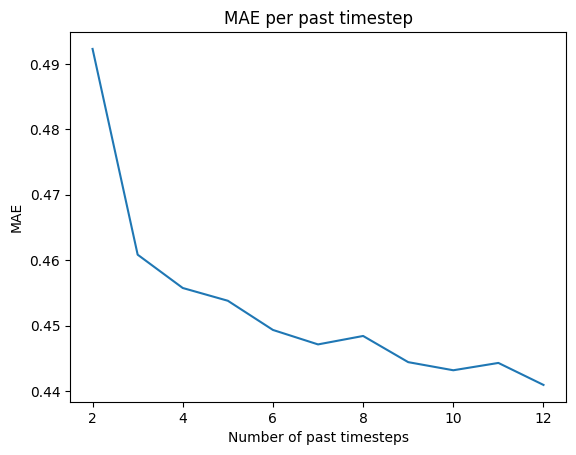

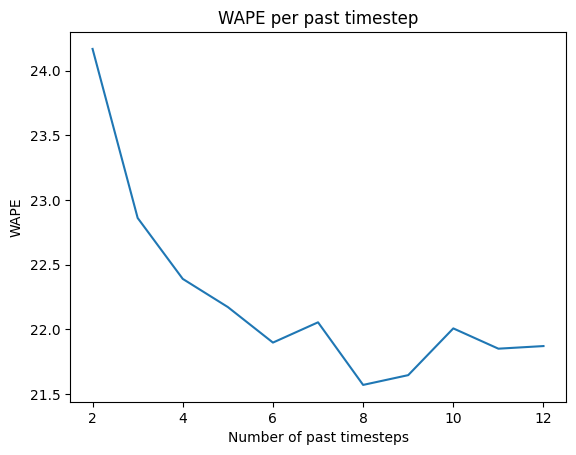

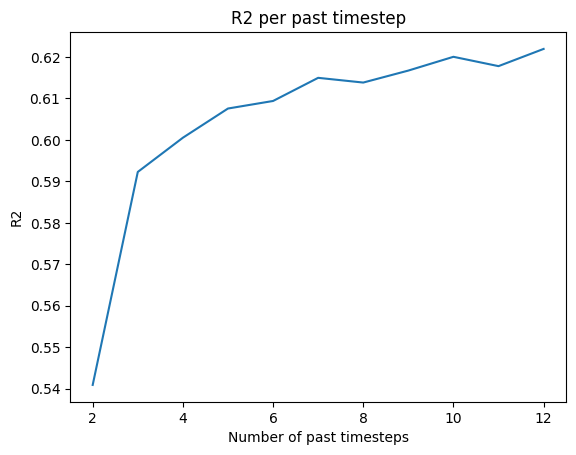

In [41]:
show_graphic_per_timestep(metrics_list_rf, number_timesteps, start_timestep=start_timestep)

## XGBoost

In [38]:
model_xgb, preds_xgb, scores_xgb, metrics_list_xgb = build_predict_show(df_total, number_timesteps, xgb.XGBRegressor(max_depth=5, learning_rate=0.1, n_estimators=100, seed=42), start_timestep=start_timestep)


Iteration  2
WAPE: 21.3489
CV MSE: 0.43962 
CV RMSE: 0.66299 
CV MAE: 0.43227 
CV R2: 0.62433 

Elapsed time: 1.916 seconds

Iteration  3
WAPE: 20.9260
CV MSE: 0.4422 
CV RMSE: 0.66486 
CV MAE: 0.43052 
CV R2: 0.62543 

Elapsed time: 2.063 seconds

Iteration  4
WAPE: 20.9245
CV MSE: 0.43898 
CV RMSE: 0.6625 
CV MAE: 0.43083 
CV R2: 0.6294 

Elapsed time: 2.420 seconds

Iteration  5
WAPE: 21.2113
CV MSE: 0.43528 
CV RMSE: 0.65964 
CV MAE: 0.43026 
CV R2: 0.63137 

Elapsed time: 2.585 seconds

Iteration  6
WAPE: 21.2745
CV MSE: 0.42655 
CV RMSE: 0.65305 
CV MAE: 0.42701 
CV R2: 0.6324 

Elapsed time: 2.785 seconds

Iteration  7
WAPE: 21.0678
CV MSE: 0.43637 
CV RMSE: 0.66052 
CV MAE: 0.42918 
CV R2: 0.63044 

Elapsed time: 2.841 seconds

Iteration  8
WAPE: 21.2371
CV MSE: 0.43289 
CV RMSE: 0.65782 
CV MAE: 0.42816 
CV R2: 0.63083 

Elapsed time: 3.308 seconds

Iteration  9
WAPE: 21.2401
CV MSE: 0.43352 
CV RMSE: 0.65839 
CV MAE: 0.42996 
CV R2: 0.63424 

Elapsed time: 5.860 seconds

Ite

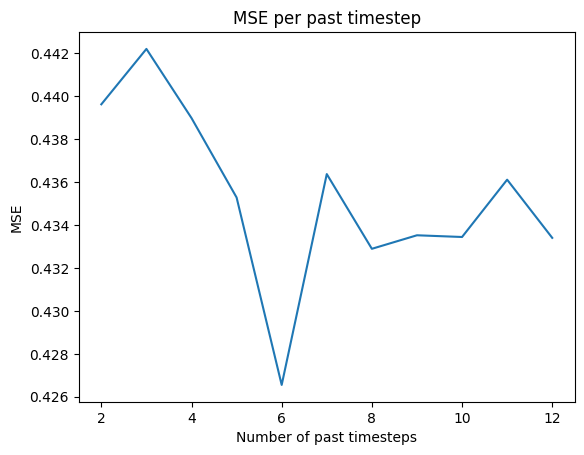

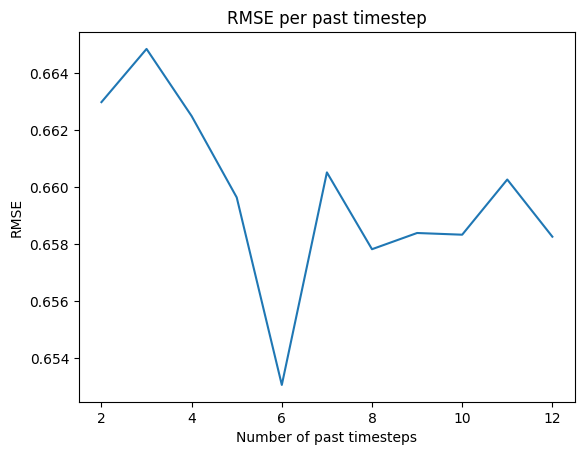

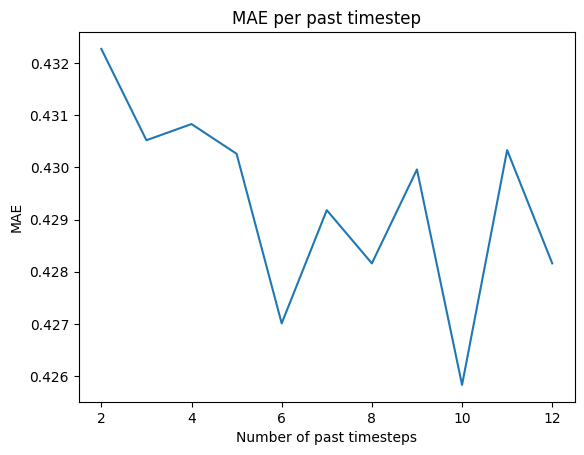

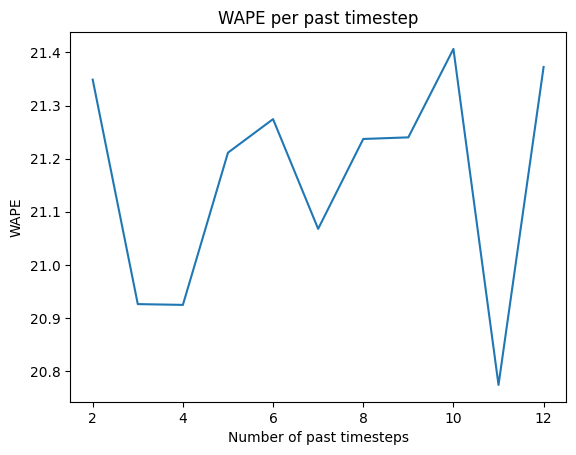

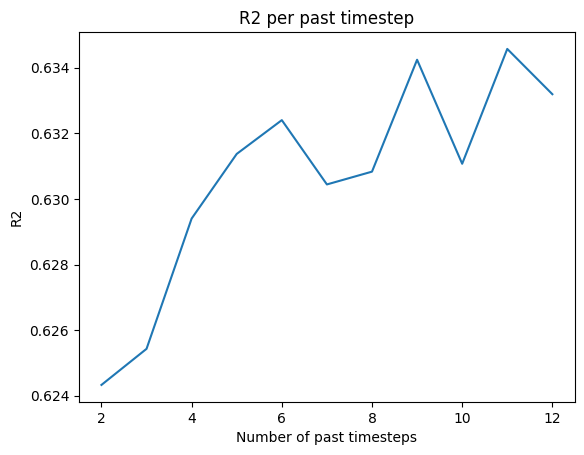

In [39]:
show_graphic_per_timestep(metrics_list_xgb, number_timesteps, start_timestep=start_timestep)

In [42]:
print(min([sublist[3] for sublist in metrics_list_gb]))
print(min([sublist[3] for sublist in metrics_list_rf]))
print(min([sublist[3] for sublist in metrics_list_xgb]))

21.006622394048666
21.57001661530284
20.773806179056965


In [43]:
def switch_metric(metric: str):
    if metric.lower() == "mse":
        m = 0
    elif metric.lower() == "rmse":
        m = 1
    elif metric.lower() == "mae":
        m = 2
    elif metric.lower() == "wape":
        m = 3
    elif metric.lower() == "r2":
        m = 4
    return m

In [44]:
def find_best_model(metric: str, metrics_list):
    met = switch_metric(metric)
    min_value = min(map(lambda x: x[met], metrics_list))
    idx = [index for index, item in enumerate(map(lambda x: x[met], metrics_list)) if item == min_value]
    return metrics_list[idx[0]]

In [45]:
all_metrics_lists = [metrics_list_gb, metrics_list_rf, metrics_list_xgb]

In [46]:
best_model = []
for model in all_metrics_lists:
    best_model.append(find_best_model("wape", model))

### Plot Best models

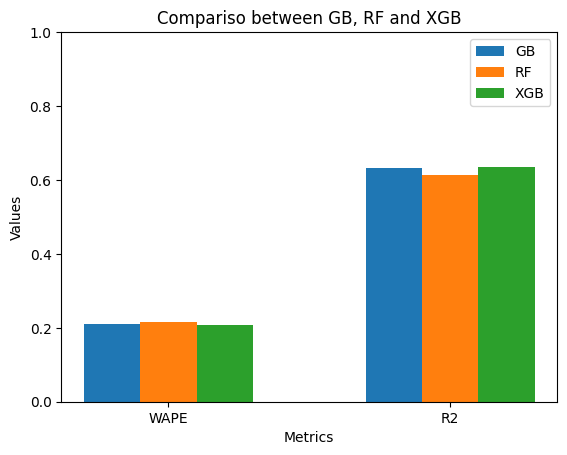

In [48]:
X_names = ("WAPE", "R2")
X_axis = np.arange(len(X_names))
plt.bar(X_axis - 0.2, (best_model[0][3] / 100, best_model[0][4]), 0.2, label = 'GB')
plt.bar(X_axis, (best_model[1][3] / 100, best_model[1][4]), 0.2, label = 'RF')
plt.bar(X_axis + 0.2, (best_model[2][3] / 100, best_model[2][4]), 0.2, label = 'XGB')
plt.ylim(0,1)
plt.xticks(X_axis, X_names)
plt.xlabel("Metrics")
plt.ylabel("Values")
plt.title("Compariso between GB, RF and XGB")
plt.legend()
plt.show()